function ClickConnect(){
console.log("Working");
document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
}
setInterval(ClickConnect,60000)

## Pipeline

1. Preprocess  
sentencize, extract_features
2. Sneak  
if sentence count <=1 then directly return
3. Compress  
extractive summarization on long paragraph
4. Model  
binary classification with threshold

## Extractive Summarization

## Base Line

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

In [3]:
# load csv
train_path = "/content/drive/Shareddrives/AI_CUP_NLP/Batch_answers - train_data (no-blank).csv"
train_data = pd.read_csv(train_path, encoding = "utf-8", index_col='id').iloc[:,:5].applymap(lambda x: x.strip('"')).reset_index()

In [4]:
train_data["length"] = train_data["q'"] + train_data["r'"]
train_data["length"] = train_data["length"].map(len)
idx = train_data.groupby(by=train_data.id)['length'].transform(max) == train_data['length']
small_train_data = train_data[idx].reset_index(drop=True)
small_train_data = small_train_data.groupby(by=small_train_data.id).first().reset_index(drop=True)

In [19]:
small_train_data['q_length'] = small_train_data['q'].map(len)
small_train_data['r_length'] = small_train_data['r'].map(len)

In [18]:
# 評分用LCS
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
punctuations = '''!"#$%&'()*+, -./:;<=>?@[\]^_`{|}~'''

def longestCommonSubsequence(text1: str, text2: str) -> int:

    text1 = [i for i in word_tokenize(text1) if len(i)>1 or i not in punctuations]
    text2 = [i for i in word_tokenize(text2) if len(i)>1 or i not in punctuations]

    if len(text2) > len(text1):
        text1, text2 = text2, text1
    lcs = [[0]*(len(text2)+1) for _ in range(2)]
    for i in range(1, len(text1)+1):
        for j in range(1, len(text2)+1):
            if text1[i-1]== text2[j-1]:
                lcs[i%2][j] = lcs[(i-1) % 2][j-1] +1
            else:
                lcs[i%2][j]= max(lcs[(i-1)%2][j], lcs[i % 2][j-1])
    lcs = lcs[len(text1)% 2][len(text2)]
    return lcs/(len(text1)+len(text2)-lcs)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
from tqdm import tqdm

In [8]:
q_score_list = []
r_score_list = []

for i in tqdm(small_train_data.index):
  try:
    q_score = longestCommonSubsequence(small_train_data['q'][i], small_train_data["q'"][i])
    r_score = longestCommonSubsequence(small_train_data['r'][i], small_train_data["r'"][i])
  except:
    q_score = -1
    r_score = -1

  
  q_score_list.append(q_score)
  r_score_list.append(r_score)

small_train_data['q_score'] = q_score_list
small_train_data['r_score'] = r_score_list
small_train_data['mean_score'] = (small_train_data['q_score'] + small_train_data['r_score'])/2

100%|██████████| 7987/7987 [00:39<00:00, 200.41it/s]


In [9]:
sum(small_train_data['q_score']==-1), sum(small_train_data['r_score']==-1)

(0, 0)

In [10]:
q_base_line = small_train_data['q_score'].sum() / small_train_data['q_score'].count()
r_base_line = small_train_data['r_score'].sum() / small_train_data['r_score'].count()
base_line = small_train_data['mean_score'].sum() / small_train_data['mean_score'].count()

q_base_line, r_base_line, base_line

(0.7111274291681386, 0.6609471793216652, 0.686037304244902)

## EDA

In [11]:
import matplotlib.pyplot as plt
import numpy as np

In [12]:
def jitter(y):
  jittered_y = y + 0.005 * np.random.rand(len(y)) -0.005 * np.random.rand(len(y))
  return jittered_y

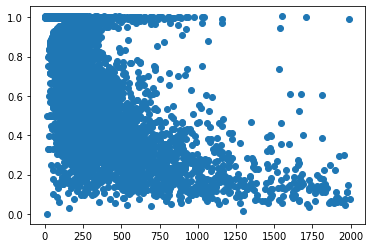

In [30]:
q_data = small_train_data[small_train_data['q_length']<=2000]
plt.scatter(q_data['q_length'], jitter(q_data['q_score']))
plt.show()

In [120]:
len(small_train_data) - len(q_data)

116

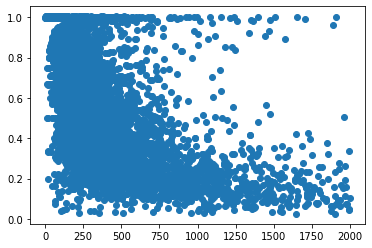

In [27]:
r_data = small_train_data[small_train_data['r_length']<=2000]
plt.scatter(r_data['r_length'], jitter(r_data['r_score']))
plt.show()

In [121]:
len(small_train_data) - len(r_data)

136

## find average max length for bert

In [52]:
from transformers import BertTokenizer
BERT_MODEL_NAME = "bert-base-uncased" # we will use the BERT base model(the smaller one)
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [110]:
test_list = []
count = 0
for i in small_train_data.index:
  if small_train_data['q_length'][i] > 5000:
    test_list.append(i)
    count+=1

In [111]:
def get_bert_length(sentence):
  input_ids = tokenizer(sentence, truncation=True)['input_ids']
  max_length = len(tokenizer.decode(input_ids, skip_special_tokens=True))
  return max_length

In [112]:
length_list = [get_bert_length(small_train_data['q'][i]) for i in test_list]

In [113]:
len(length_list)

27

In [114]:
list(np.quantile(length_list, q = np.array([0, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 1])))

[2078.0, 2119.86, 2245.6, 2295.0, 2430.0, 2482.0, 2515.6, 2624.44, 2652.0]

In [115]:
r_test_list = []
for i in small_train_data.index:
  if small_train_data['r_length'][i] > 5000:
    r_test_list.append(i)

In [116]:
r_length_list = [get_bert_length(small_train_data['r'][i]) for i in r_test_list]

In [117]:
len(r_length_list)

25

In [118]:
list(np.quantile(r_length_list, q = np.array([0, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 1])))

[1796.0, 1831.28, 2120.0, 2257.0, 2320.0, 2349.0, 2476.0, 2491.84, 2494.0]

## Extractive bert

In [15]:
!pip install -q bert-extractive-summarizer
!pip install -q transformers
!pip install -q spacy
!pip install -q gensim==3.8.0
!pip install -q pysummarization

     |████████████████████████████████| 5.5 MB 7.7 MB/s 
     |████████████████████████████████| 182 kB 64.6 MB/s 
     |████████████████████████████████| 7.6 MB 36.4 MB/s 
     |████████████████████████████████| 24.2 MB 1.3 MB/s 
     |████████████████████████████████| 64 kB 1.5 MB/s 


In [ ]:
from summarizer import Summarizer,TransformerSummarizer
bert_model = Summarizer()
def bert_summarize(sentence, length):
  if length<=2000:
    return sentence
  bert_summary = ''.join(bert_model(sentence, max_length=2000))
  return bert_summary

In [50]:
import warnings
warnings.filterwarnings("ignore")

In [128]:
small_train_data['q_summary'] = ''
small_train_data['r_summary'] = ''

for i in tqdm(small_train_data.index):
  small_train_data['q_summary'][i] = bert_summarize(small_train_data['q'][i], small_train_data['q_length'][i])
  small_train_data['r_summary'][i] = bert_summarize(small_train_data['r'][i], small_train_data['r_length'][i])

100%|██████████| 7987/7987 [1:02:14<00:00,  2.14it/s]


In [130]:
import pickle

In [132]:
# Save
with open('/content/drive/Shareddrives/AI_CUP_NLP/summary.pickle', 'wb') as f:
    pickle.dump(small_train_data, f)

In [ ]:
# Load
# with open('/content/drive/Shareddrives/AI_CUP_NLP/summary.pickle', 'rb') as f:
#     summary = pickle.load(f)

## Test Data

In [16]:
test_df = pd.read_csv('/content/drive/Shareddrives/AI_CUP_NLP/Batch_answers - test_data(no_label).csv', index_col='id')

In [17]:
fake_answer = test_df.drop('s', axis=1)
fake_answer.to_csv('/content/drive/Shareddrives/AI_CUP_NLP/fake_answer.csv')